## Load data and library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [523]:
loader = DataLoader()
d = loader.GetData('final')

In [316]:
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,Class,Prompt,score,text
0,1003246377,21120199,古丽依娜·买买提克力木,2021-22冬季通用英语C2刘学青1005期末,法学院,1002658406(刘学青),C,19121438,9.0,...
1,1003248323,21122145,王名振,2021-22冬季通用英语B2谢怡沁1014期末,通信与信息工程学院,1002658415(谢怡沁),B,19121435,9.6,"As a person, the people around us are always c..."
2,1003249593,21123420,周祺,2021-22冬季通用英语C2刘学青1016期末,上海美术学院,1002658406(刘学青),C,19121440,8.7,"Since we are little, we have been told to read..."
3,1003250643,21124470,张芷昕,2021-22冬季通用学术英语A2张新玲1008期末,音乐学院,1002658431(张新玲),A,1000561535,11.1,"With the development of networks, Internet i..."
4,1003246209,21120031,晏三,2021-22冬季通用英语B2谢怡沁1014期末,法学院,1002658415(谢怡沁),B,19121437,10.5,"As we all know, friendship is essential for th..."


In [524]:
clean_text = []
preproc = preprocessing.make_pipeline(preprocessing.normalize.whitespace)
for essay in d['text']:
    cleaned = preproc(essay.replace("'s", "'s '").replace('\n',''))
    clean_text.append(cleaned)
d['text'] = clean_text

In [525]:
d.loc[:,'level'] = 0
percentiles = []
for i in range(10,100,10):
    percentiles.append(np.percentile(d['score'],i))
d.loc[d['score'] <= percentiles[0],'level'] = '100'
for i in range(8):
    d.loc[(d['score'] <= percentiles[i+1]) & (d['score'] > percentiles[i]),'level'] = str((10-i-1)*10)
d.loc[d['score'] > percentiles[-1],'level'] = '10'
d = d.loc[d['score'] != 0]
##d = d[d['Prompt'] == 19121438]
#d = d[d['任课教师'].isin(['1002658413(白静远)','1002658414(薛清)','1002658415(谢怡沁)'])]

### VAC list

In [497]:
with open('features/final-winter-vac.txt') as f:
    vac_docs =f.readlines()

## LSA
### TF-IDF encodings for vac

In [517]:
vector = TfidfVectorizer(max_features=500,max_df=0.85)
features = vector.fit_transform([doc_sent[d.index[i]] for i in range(len(d.index))])

In [518]:
svd = TruncatedSVD(10)
features = svd.fit_transform(features)

## Plot clustering results
### Set color labels

In [459]:
sns.color_palette("hls",10)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6207999999999999)]

In [521]:
colors= dict()
count = 0
for i in list(d['level']):
    if not i in colors:
        colors[i] = sns.color_palette("rocket",10)[count]
        count += 1
label_color = [colors[d['level'][i]] for i in d.index]

### Hierarchy clustering

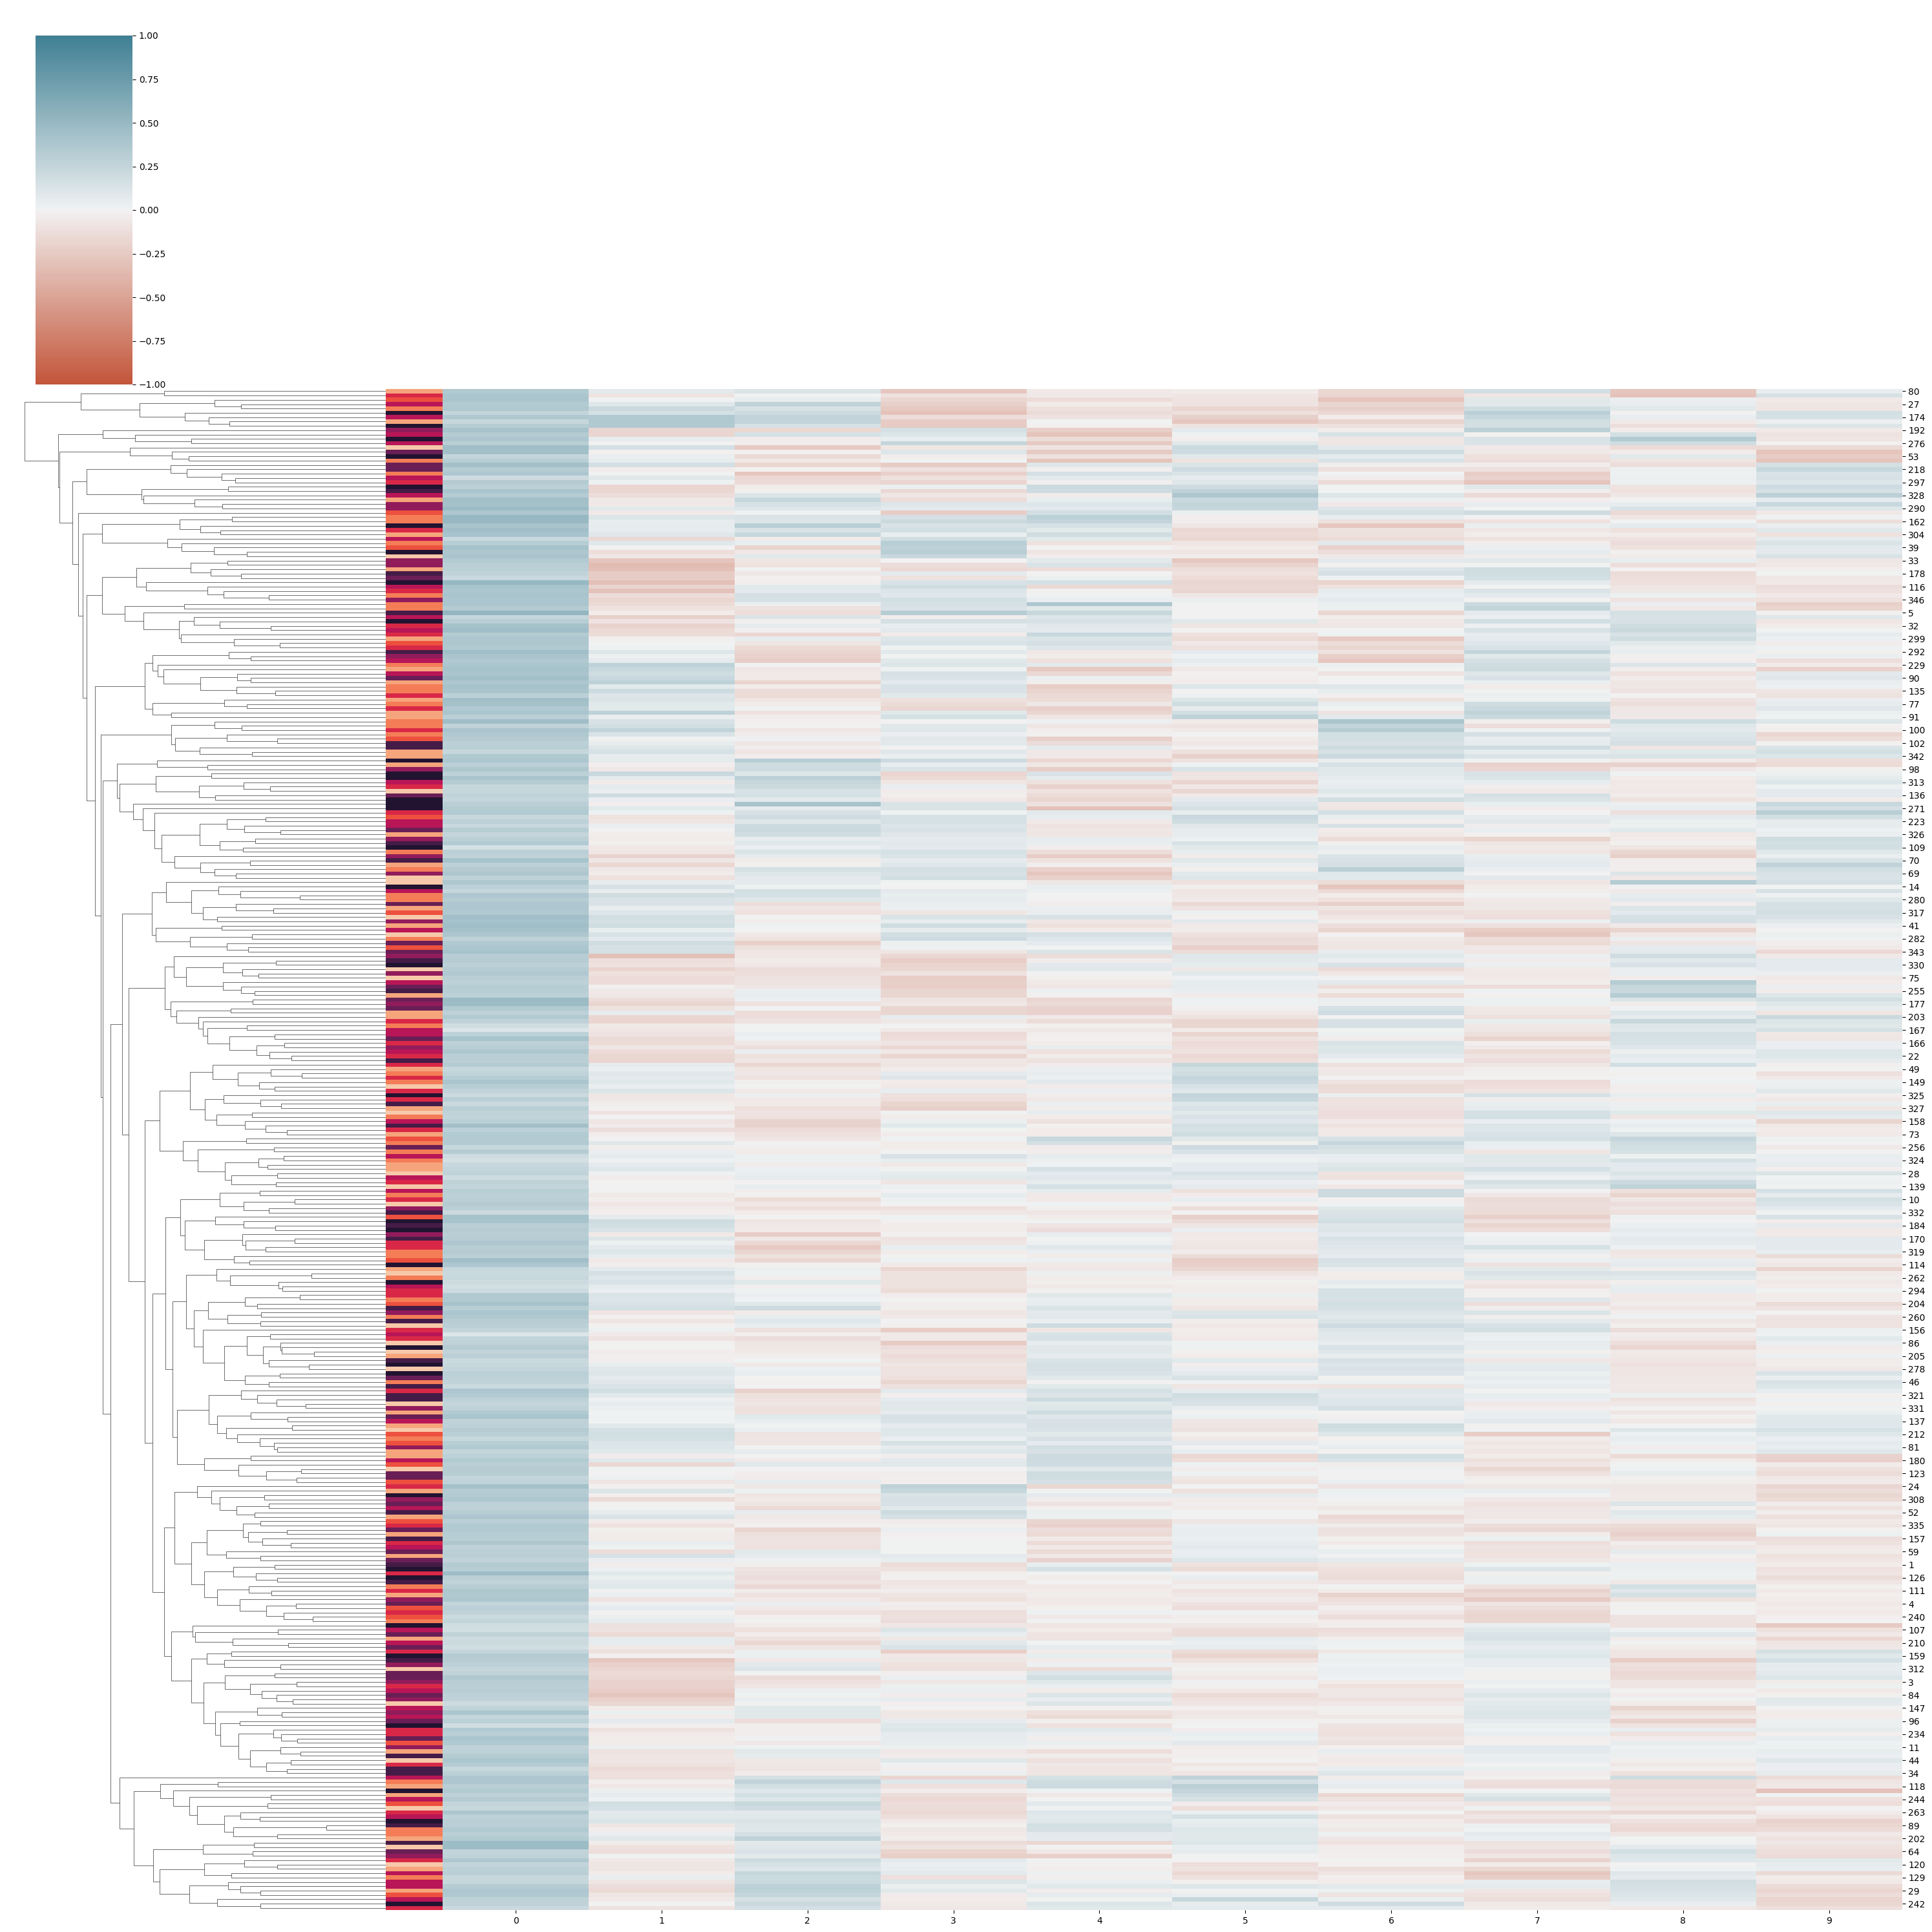

In [522]:
sns.clustermap(features,figsize = (30,30),vmin=-1,vmax=1,center=0,cmap=cmap,row_colors=label_color,col_cluster=False)

### T-SNE for visualization

In [462]:
vis = TSNE()
pos = vis.fit_transform(features)

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### K-means clustering

In [489]:
cluster_model = KMeans(10)
cluster_labels = cluster_model.fit_predict(features)

In [490]:
d['label'] = [str(i)  for i in cluster_labels]

C:\Users\GIGA\AppData\Local\Temp\ipykernel_23100\4274928752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['label'] = [str(i)  for i in cluster_labels]


In [491]:
cluster_true = {19121438: 5,
 19121435: 8,
 19121440: 2,
 1000561535: 9,
 19121437: 6,
 19121436: 1,
 19121416: 3,
 19121413: 7,
 19121417: 4,
 19121439: 0}

In [492]:
clusters = cluster_true.copy()
for name in cluster_true:
    clu = [i for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_true[name]]
    clusters[name] = clu

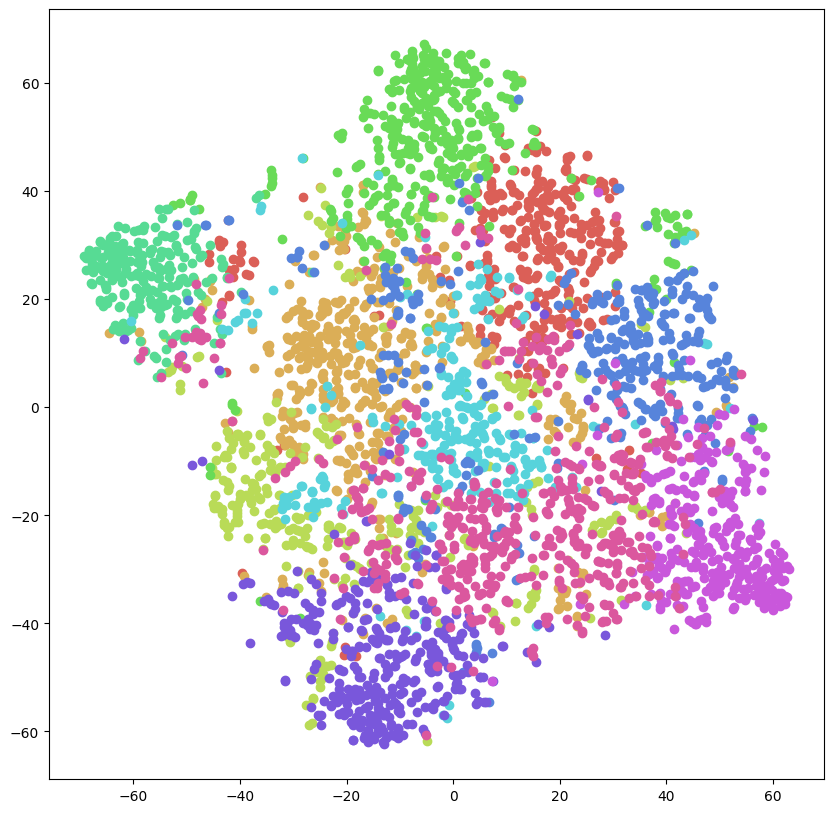

In [493]:
ax = plt.subplots(1,1,figsize = (10,10))
for clu in clusters:
    x = []
    y = []
    for i in clusters[clu]:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y,color = colors[clu],label = clu)
    #plt.legend(loc='best')

### Plot true labels

In [494]:
true_labels = list(d['Prompt'])
clusters = dict([(Cluster_name,[]) for Cluster_name in d['Prompt']])
for i in range(len(true_labels)):
    if true_labels[i] in clusters:
        clusters[true_labels[i]].append(i)
    else:
        clusters[true_labels[i]] = [i]
c = [tuple(clusters[i]) for i in clusters]

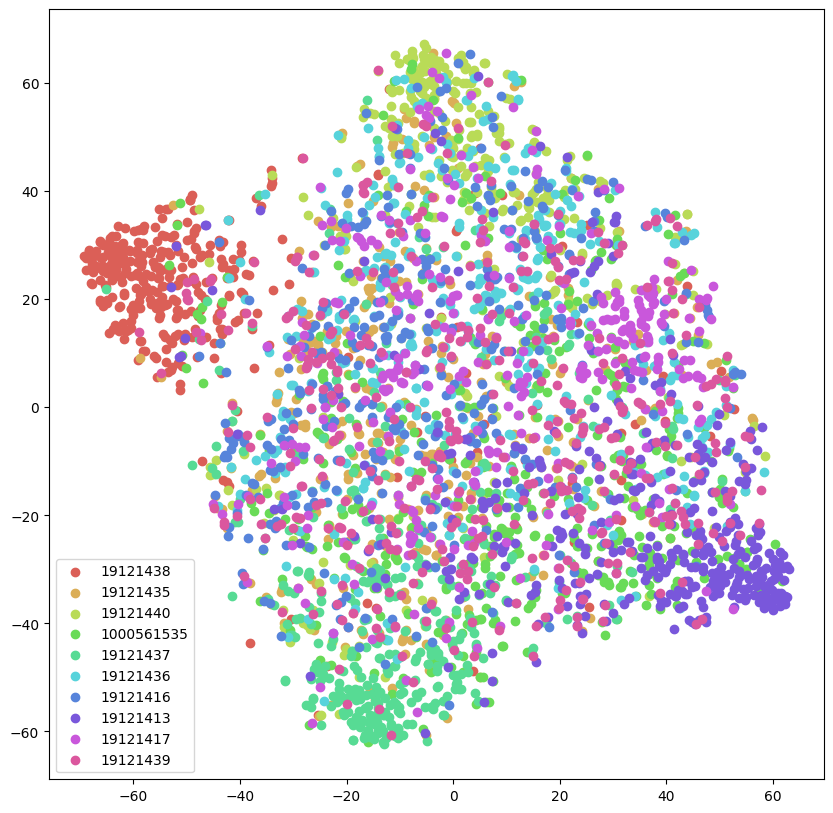

In [495]:
ax = plt.subplots(1,1,figsize = (10,10))
for clu in clusters:
    x = []
    y = []
    for i in clusters[clu]:
        x.append(pos[i, 0])
        y.append(pos[i,1])
    plt.scatter(x,y,color = colors[clu],label = clu)
    plt.legend(loc='best')

### Table for most important VACs

In [500]:
dictionary = vector.get_feature_names_out()
topic_values = []
for t in svd.components_:
    values = [(dictionary[i],t[i]) for i in range(len(t))]
    topic_values.append(sorted(values,key=lambda x:abs(x[1]),reverse=True))
for v in topic_values:
    for vac in v[:5]:
        print('{}: {:.2f}'.format(vac[0],vac[1]),end=', ')
    print('\n')

_v_dobj: 0.48, aux_v_dobj: 0.36, _v_: 0.23, _v_prep: 0.23, nsubj_v_dobj: 0.22, 

_v_dobj: -0.67, _v_prep: 0.59, nsubj_v_dobj: 0.20, _v_: -0.14, aux_v_ccomp: 0.14, 

_v_prep: 0.66, _v_dobj: 0.35, aux_v_dobj: -0.31, nsubj_v_dobj: -0.29, aux_v_ccomp: -0.22, 

aux_v_dobj: -0.64, nsubj_v_dobj: 0.51, aux_v_ccomp: 0.23, _v_ccomp: 0.20, _v_dobj: 0.17, 

aux_v_acomp: 0.68, _v_acomp: 0.44, advmod_aux_v_acomp: 0.28, nsubj_v_dobj: -0.17, _v_dobj: -0.15, 

_v_: 0.87, _v_dobj: -0.27, aux_v_acomp: -0.18, aux_v_: 0.16, _v_cc_conj: 0.14, 

nsubj_aux_v_dobj: 0.40, nsubj_v_ccomp: 0.38, aux_v_ccomp: -0.27, _v_dobj_prep: -0.26, mark_nsubj_aux_v_dobj: 0.25, 

aux_v_: 0.48, nsubj_v_xcomp: 0.42, aux_v_dobj: -0.34, nsubj_aux_v_dobj: 0.29, _v_dobj_prep: 0.29, 

nsubj_aux_v_dobj: 0.45, _v_dobj_prep: 0.38, nsubj_v_xcomp: -0.27, aux_v_prt_dobj: 0.26, aux_v_prep: -0.26, 

aux_v_dobj_prep: 0.41, mark_nsubj_aux_v_dobj: 0.41, aux_v_: -0.32, aux_v_dobj: -0.30, aux_v_prep: 0.24, 



### A few examples

In [514]:
exp = []
for i in d[d['Prompt'] == 19121438].index:
    doc = NLP(d['text'][i])
    sents = [j for j in doc.sents if len(str(j).split()) > 3]
    dep_sent = ''
    for s in sents:
        t = s.root
        left = [m.dep_ for m in t.lefts if m.text.isalpha()]
        right = [m.dep_ for m in t.rights if m.text.isalpha()]
        vac = '_'.join(left) + '_V_' + '_'.join(right)
        dep_sent += vac
        dep_sent += ', '
        if 'acomp' in right:
            exp.append(s)
            break
    if len(exp)>10:
        break
exp

[How to keep fit?,
 Therefore, it is important for us to take meals properly and regularly.,
 However,some people are still unaware of the importance of health,having junk food and are relunctant to do exercise,leading to several serious problems.,
 First of all, a balanced diet is essential.,
 Besides eating, enough exercising is also necessary for keeping fit.,
 No need to doubt, keeping fit is significant to keep us from COVID.,
 how to keep fit ?,
 In a near future you will be fit if you do as I said.,
 However, it's ' necessary to take the right to get fit instead of losing weight by going on a diet.,
 However,many of us are unable to keep fit.,
 At first,It's ' necessary to make a definition of 'fit'.]

In [527]:
with open('features/final-winter-dep.txt') as f:
    essay_in_sent =f.readlines()

In [542]:
cttr = []
for i in range(len(essay_in_sent)):
    txt = essay_in_sent[i].split(', ')
    count = 1
    sttr = 0
    if len(txt) < 50:
        typec = len(set(txt[:len(txt)]))
        ttr = typec/len(txt)
        sttr += ttr
        cttr.append(sttr)
        continue
    for num in range(len(txt) // 50):
        typec = len(set(txt[num*50:(num+1)*50]))
        ttr = typec/50
        sttr += ttr
        count += 1
    typec = len(set(txt[len(txt) // 50 * 50:len(txt)]))
    ttr = typec/(len(txt) -( len(txt) // 50 * 50)+ 1)
    sttr += ttr
    cttr.append(sttr/(count + 1))

In [543]:
cttr = [cttr[i] for i in range(len(cttr)) if i in d.index]

In [544]:
TrainX,TestX = np.array(cttr[:2500]).reshape(2500,1),np.array(cttr[2500:]).reshape(1284,1)

In [501]:
TrainX,TestX = features[:2500],features[2500:]

In [545]:
TrainY,TestY = d.loc[d.index[:2500],'score'],d.loc[d.index[2500:],'score']

In [546]:
model = linear_model.Ridge()
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)

In [547]:
explained_variance_score(TestY,PredY)

0.006236530893359737

In [474]:
mean_squared_error(TestY,PredY,squared = False)

1.331491583162773

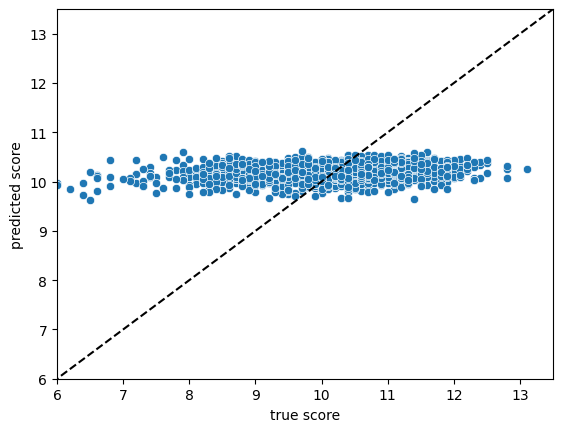

In [548]:
g = sns.scatterplot(x=TestY,y=PredY)
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((6,13.5))
g.set_xlim((6,13.5))
g = sns.lineplot(x=[0,13.5],y=[0,13.5],color='black')
g.lines[0].set_linestyle("--")